In [320]:
import networkx as nx
import matplotlib.pyplot as plt
import random
import numpy as np
import mxnet as mx
import logging
from sklearn.metrics import accuracy_score

In [252]:
NUM_NODE = 100
WEIGHT_MIN = .0
WEIGHT_MAX = 1.
OUT_DEGREE_MAX = 10

In [253]:
def generate_rand_weighted_g(node_size=NUM_NODE, p=0.05, directed=True, weight_min=WEIGHT_MIN, weight_max=WEIGHT_MAX):

    rnd_g = nx.erdos_renyi_graph(node_size, p, directed=directed)

    for edge in rnd_g.edges(data=True):
        rnd_g.add_edge(edge[0], edge[1], weight=random.uniform(weight_min, weight_max))
        
    return rnd_g

def print_g(G):
    for edge in G.edges(data=True):
        print(edge)

In [254]:
G = generate_rand_weighted_g(node_size=NUM_NODE)

print_g(G)

(0, 97, {'weight': 0.08358785062925056})
(0, 66, {'weight': 0.7634143565999103})
(0, 69, {'weight': 0.06171691714318861})
(0, 60, {'weight': 0.3316649964909534})
(0, 92, {'weight': 0.7839283177327799})
(0, 31, {'weight': 0.9632729011266646})
(1, 24, {'weight': 0.09722446931430062})
(1, 49, {'weight': 0.627910209934466})
(1, 54, {'weight': 0.8307191854070051})
(1, 30, {'weight': 0.9945325792120301})
(1, 15, {'weight': 0.6436885279401915})
(2, 0, {'weight': 0.7038574513185115})
(2, 82, {'weight': 0.7980743032580668})
(2, 35, {'weight': 0.8227885084945905})
(2, 78, {'weight': 0.2391918641470011})
(3, 33, {'weight': 0.9979970684924421})
(3, 82, {'weight': 0.045943416078371935})
(3, 52, {'weight': 0.2887652376808302})
(3, 89, {'weight': 0.9875421280835874})
(4, 96, {'weight': 0.6515003648286398})
(4, 51, {'weight': 0.14115309810617716})
(4, 66, {'weight': 0.7126841703787815})
(4, 67, {'weight': 0.508778778846733})
(4, 97, {'weight': 0.5841831670839507})
(4, 37, {'weight': 0.9375784744600245

In [256]:
print(G.number_of_nodes())
print(G.number_of_edges())

100
503


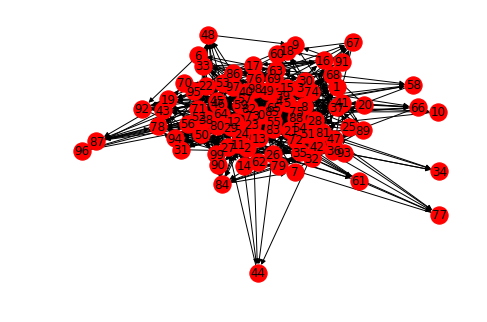

In [257]:
nx.draw(G, with_labels=True)
plt.show()

In [258]:
max_out_degree = max(G.out_degree, key=lambda d: d[1])[1]
max_out_degree

11

In [259]:
X, y = [], []

def one_hot_encode(idx, length=max_out_degree):
    
    ret = np.zeros(length)
    ret[idx] = 1.0
    return ret

for node in G.nodes:
    
    if G.out_degree(node) == 0:
        continue

    init_weight_vec = np.ones(max_out_degree)
    
    for idx, out_edge in enumerate(G.out_edges(node)):
        init_weight_vec[idx] = G.get_edge_data(node, out_edge[1])['weight']
    
    out_neighbors = map(lambda t: (t[1], G.get_edge_data(node, t[1])['weight']),  G.out_edges(node))
#     print(node, min(out_neighbors, key=lambda d: d[1]), len(out_neighbors), sorted(out_neighbors))
    
#     label = one_hot_encode(np.argmin(init_weight_vec, axis=0))
    label = min(out_neighbors, key=lambda d: d[1])[1]
#     print(label, init_weight_vec[np.argmin(init_weight_vec)])
    assert label == init_weight_vec[np.argmin(init_weight_vec)]
    X.append(init_weight_vec)
    y.append(label)
    
features = np.array(X)
labels = np.array(y)

In [260]:
print(X[0])
print(y[0])

[ 0.08358785  0.76341436  0.06171692  0.331665    0.78392832  0.9632729   1.
  1.          1.          1.          1.        ]
0.0617169171432


In [261]:
def augment_dataset(X, y=None, augmentation_index=10):
    
    X_aug, y_aug = [], []
    indices = np.arange(len(X[0]))
    
    for idx, x in enumerate(X):
        for _ in range(augmentation_index):
            np.random.shuffle(indices)
            X_aug.append(x[indices])
            y_aug.append(one_hot_encode(np.argmin(x[indices])))
    
    return np.array(X_aug), np.array(y_aug)

In [487]:
X_aug, y_aug = augment_dataset(features, labels, augmentation_index=200)
print(X_aug.shape)
print(y_aug.shape)

(20000, 11)
(20000, 11)


In [488]:
print(X_aug[1])
print(y_aug[1])

[ 1.          0.06171692  1.          1.          0.76341436  0.331665
  0.78392832  0.08358785  1.          0.9632729   1.        ]
[ 0.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.]


In [489]:
indices = np.arange(len(X_aug))
np.random.shuffle(indices)
X, y =  X_aug[indices], y_aug[indices]
print(X.shape)
print(y.shape)

(20000, 11)
(20000, 11)


In [490]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.9, random_state=42)
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(18000, 11)
(18000, 11)
(2000, 11)
(2000, 11)


In [506]:
batch_size = 100

train_iter = mx.io.NDArrayIter(X_train, y_train, batch_size, shuffle=True)
val_iter = mx.io.NDArrayIter(X_test, y_test, batch_size=len(y_test))

In [507]:
def build_model(context=mx.gpu()):
    
    data = mx.sym.var('data')
    label = mx.sym.var('softmax_label')
    
    fc2  = mx.sym.FullyConnected(data=data, num_hidden=32)
    fc2 = mx.sym.Activation(data=fc2, act_type="relu")
    
    fc3  = mx.sym.FullyConnected(data=fc2, num_hidden=max_out_degree)
    mlp  = mx.sym.SoftmaxOutput(data=fc3, label=label)
    
    return mx.mod.Module(symbol=mlp, context=context)

In [508]:
logging.getLogger().setLevel(logging.DEBUG)  # logging to stdout
model = build_model()
model.bind(data_shapes=train_iter.provide_data, label_shapes=train_iter.provide_label)
model.init_params()

In [509]:
def custom_acc(label, pred):
    tmp_label = np.argmax(label, axis=1)
    tmp_pred = np.argmax(pred, axis=1)
    return accuracy_score(tmp_label, tmp_pred)

custom_metric = mx.metric.create(custom_acc)

In [512]:
model.fit(train_iter,  # train data
              eval_data=val_iter,  # validation data
              optimizer='adam',  # use SGD to train
#               optimizer_params={'learning_rate':0.01, 'momentum': 0.9},
              eval_metric=custom_metric,  # report accuracy during training
              batch_end_callback = mx.callback.Speedometer(batch_size, 10), # output progress for each 100 data batches
              num_epoch=50)  # train for at most 10 dataset passes

INFO:root:Epoch[0] Batch [10]	Speed: 95440.05 samples/sec	custom_acc=0.939091
INFO:root:Epoch[0] Batch [20]	Speed: 103211.38 samples/sec	custom_acc=0.955000
INFO:root:Epoch[0] Batch [30]	Speed: 111494.30 samples/sec	custom_acc=0.944000
INFO:root:Epoch[0] Batch [40]	Speed: 92353.00 samples/sec	custom_acc=0.932000
INFO:root:Epoch[0] Batch [50]	Speed: 104559.61 samples/sec	custom_acc=0.937000
INFO:root:Epoch[0] Batch [60]	Speed: 82664.30 samples/sec	custom_acc=0.951000
INFO:root:Epoch[0] Batch [70]	Speed: 77778.88 samples/sec	custom_acc=0.939000
INFO:root:Epoch[0] Batch [80]	Speed: 103338.52 samples/sec	custom_acc=0.935000
INFO:root:Epoch[0] Batch [90]	Speed: 68273.33 samples/sec	custom_acc=0.952000
INFO:root:Epoch[0] Batch [100]	Speed: 66643.96 samples/sec	custom_acc=0.952000
INFO:root:Epoch[0] Batch [110]	Speed: 83132.90 samples/sec	custom_acc=0.959000
INFO:root:Epoch[0] Batch [120]	Speed: 67104.57 samples/sec	custom_acc=0.956000
INFO:root:Epoch[0] Batch [130]	Speed: 80985.19 samples/se

INFO:root:Epoch[5] Batch [110]	Speed: 105152.03 samples/sec	custom_acc=0.960000
INFO:root:Epoch[5] Batch [120]	Speed: 106427.40 samples/sec	custom_acc=0.957000
INFO:root:Epoch[5] Batch [130]	Speed: 107978.17 samples/sec	custom_acc=0.949000
INFO:root:Epoch[5] Batch [140]	Speed: 103435.36 samples/sec	custom_acc=0.950000
INFO:root:Epoch[5] Batch [150]	Speed: 105107.23 samples/sec	custom_acc=0.953000
INFO:root:Epoch[5] Batch [160]	Speed: 103842.54 samples/sec	custom_acc=0.940000
INFO:root:Epoch[5] Batch [170]	Speed: 94374.91 samples/sec	custom_acc=0.944000
INFO:root:Epoch[5] Train-custom_acc=0.943333
INFO:root:Epoch[5] Time cost=0.211
INFO:root:Epoch[5] Validation-custom_acc=0.948000
INFO:root:Epoch[6] Batch [10]	Speed: 101895.00 samples/sec	custom_acc=0.940909
INFO:root:Epoch[6] Batch [20]	Speed: 93291.75 samples/sec	custom_acc=0.957000
INFO:root:Epoch[6] Batch [30]	Speed: 96545.07 samples/sec	custom_acc=0.948000
INFO:root:Epoch[6] Batch [40]	Speed: 109039.26 samples/sec	custom_acc=0.9370

INFO:root:Epoch[11] Batch [30]	Speed: 85135.87 samples/sec	custom_acc=0.948000
INFO:root:Epoch[11] Batch [40]	Speed: 102700.88 samples/sec	custom_acc=0.940000
INFO:root:Epoch[11] Batch [50]	Speed: 109864.68 samples/sec	custom_acc=0.942000
INFO:root:Epoch[11] Batch [60]	Speed: 111310.85 samples/sec	custom_acc=0.949000
INFO:root:Epoch[11] Batch [70]	Speed: 103637.27 samples/sec	custom_acc=0.939000
INFO:root:Epoch[11] Batch [80]	Speed: 104580.46 samples/sec	custom_acc=0.940000
INFO:root:Epoch[11] Batch [90]	Speed: 111222.30 samples/sec	custom_acc=0.956000
INFO:root:Epoch[11] Batch [100]	Speed: 101213.90 samples/sec	custom_acc=0.957000
INFO:root:Epoch[11] Batch [110]	Speed: 92747.14 samples/sec	custom_acc=0.963000
INFO:root:Epoch[11] Batch [120]	Speed: 101060.26 samples/sec	custom_acc=0.959000
INFO:root:Epoch[11] Batch [130]	Speed: 100623.85 samples/sec	custom_acc=0.950000
INFO:root:Epoch[11] Batch [140]	Speed: 106997.55 samples/sec	custom_acc=0.951000
INFO:root:Epoch[11] Batch [150]	Speed

INFO:root:Epoch[16] Batch [120]	Speed: 106836.75 samples/sec	custom_acc=0.960000
INFO:root:Epoch[16] Batch [130]	Speed: 99167.84 samples/sec	custom_acc=0.950000
INFO:root:Epoch[16] Batch [140]	Speed: 106144.60 samples/sec	custom_acc=0.952000
INFO:root:Epoch[16] Batch [150]	Speed: 104079.60 samples/sec	custom_acc=0.957000
INFO:root:Epoch[16] Batch [160]	Speed: 108812.95 samples/sec	custom_acc=0.941000
INFO:root:Epoch[16] Batch [170]	Speed: 97694.17 samples/sec	custom_acc=0.949000
INFO:root:Epoch[16] Train-custom_acc=0.944444
INFO:root:Epoch[16] Time cost=0.211
INFO:root:Epoch[16] Validation-custom_acc=0.951500
INFO:root:Epoch[17] Batch [10]	Speed: 109289.28 samples/sec	custom_acc=0.944545
INFO:root:Epoch[17] Batch [20]	Speed: 95392.30 samples/sec	custom_acc=0.957000
INFO:root:Epoch[17] Batch [30]	Speed: 91091.41 samples/sec	custom_acc=0.948000
INFO:root:Epoch[17] Batch [40]	Speed: 69545.75 samples/sec	custom_acc=0.942000
INFO:root:Epoch[17] Batch [50]	Speed: 89436.51 samples/sec	custom_

INFO:root:Epoch[22] Batch [30]	Speed: 107897.62 samples/sec	custom_acc=0.952000
INFO:root:Epoch[22] Batch [40]	Speed: 111110.33 samples/sec	custom_acc=0.944000
INFO:root:Epoch[22] Batch [50]	Speed: 106793.23 samples/sec	custom_acc=0.948000
INFO:root:Epoch[22] Batch [60]	Speed: 107526.96 samples/sec	custom_acc=0.950000
INFO:root:Epoch[22] Batch [70]	Speed: 105898.05 samples/sec	custom_acc=0.944000
INFO:root:Epoch[22] Batch [80]	Speed: 105908.74 samples/sec	custom_acc=0.941000
INFO:root:Epoch[22] Batch [90]	Speed: 105841.93 samples/sec	custom_acc=0.957000
INFO:root:Epoch[22] Batch [100]	Speed: 107839.36 samples/sec	custom_acc=0.959000
INFO:root:Epoch[22] Batch [110]	Speed: 109098.82 samples/sec	custom_acc=0.967000
INFO:root:Epoch[22] Batch [120]	Speed: 103994.45 samples/sec	custom_acc=0.961000
INFO:root:Epoch[22] Batch [130]	Speed: 108307.18 samples/sec	custom_acc=0.952000
INFO:root:Epoch[22] Batch [140]	Speed: 103155.53 samples/sec	custom_acc=0.952000
INFO:root:Epoch[22] Batch [150]	Spe

INFO:root:Epoch[27] Batch [120]	Speed: 104690.10 samples/sec	custom_acc=0.962000
INFO:root:Epoch[27] Batch [130]	Speed: 95255.81 samples/sec	custom_acc=0.952000
INFO:root:Epoch[27] Batch [140]	Speed: 88369.97 samples/sec	custom_acc=0.951000
INFO:root:Epoch[27] Batch [150]	Speed: 105719.21 samples/sec	custom_acc=0.960000
INFO:root:Epoch[27] Batch [160]	Speed: 103145.39 samples/sec	custom_acc=0.943000
INFO:root:Epoch[27] Batch [170]	Speed: 99029.70 samples/sec	custom_acc=0.951000
INFO:root:Epoch[27] Train-custom_acc=0.945556
INFO:root:Epoch[27] Time cost=0.233
INFO:root:Epoch[27] Validation-custom_acc=0.952000
INFO:root:Epoch[28] Batch [10]	Speed: 55054.20 samples/sec	custom_acc=0.949091
INFO:root:Epoch[28] Batch [20]	Speed: 82229.97 samples/sec	custom_acc=0.962000
INFO:root:Epoch[28] Batch [30]	Speed: 64724.92 samples/sec	custom_acc=0.952000
INFO:root:Epoch[28] Batch [40]	Speed: 73169.65 samples/sec	custom_acc=0.944000
INFO:root:Epoch[28] Batch [50]	Speed: 58636.99 samples/sec	custom_ac

INFO:root:Epoch[33] Batch [30]	Speed: 107853.22 samples/sec	custom_acc=0.953000
INFO:root:Epoch[33] Batch [40]	Speed: 105932.82 samples/sec	custom_acc=0.946000
INFO:root:Epoch[33] Batch [50]	Speed: 103252.03 samples/sec	custom_acc=0.947000
INFO:root:Epoch[33] Batch [60]	Speed: 101687.49 samples/sec	custom_acc=0.953000
INFO:root:Epoch[33] Batch [70]	Speed: 108273.63 samples/sec	custom_acc=0.943000
INFO:root:Epoch[33] Batch [80]	Speed: 104351.50 samples/sec	custom_acc=0.943000
INFO:root:Epoch[33] Batch [90]	Speed: 108531.39 samples/sec	custom_acc=0.959000
INFO:root:Epoch[33] Batch [100]	Speed: 104429.44 samples/sec	custom_acc=0.960000
INFO:root:Epoch[33] Batch [110]	Speed: 106010.46 samples/sec	custom_acc=0.965000
INFO:root:Epoch[33] Batch [120]	Speed: 103476.19 samples/sec	custom_acc=0.962000
INFO:root:Epoch[33] Batch [130]	Speed: 109577.66 samples/sec	custom_acc=0.952000
INFO:root:Epoch[33] Batch [140]	Speed: 92251.44 samples/sec	custom_acc=0.951000
INFO:root:Epoch[33] Batch [150]	Spee

INFO:root:Epoch[38] Batch [120]	Speed: 101904.91 samples/sec	custom_acc=0.963000
INFO:root:Epoch[38] Batch [130]	Speed: 97512.47 samples/sec	custom_acc=0.954000
INFO:root:Epoch[38] Batch [140]	Speed: 109514.71 samples/sec	custom_acc=0.952000
INFO:root:Epoch[38] Batch [150]	Speed: 94154.58 samples/sec	custom_acc=0.960000
INFO:root:Epoch[38] Batch [160]	Speed: 100069.28 samples/sec	custom_acc=0.946000
INFO:root:Epoch[38] Batch [170]	Speed: 101174.84 samples/sec	custom_acc=0.954000
INFO:root:Epoch[38] Train-custom_acc=0.946667
INFO:root:Epoch[38] Time cost=0.230
INFO:root:Epoch[38] Validation-custom_acc=0.953000
INFO:root:Epoch[39] Batch [10]	Speed: 108920.33 samples/sec	custom_acc=0.950000
INFO:root:Epoch[39] Batch [20]	Speed: 104069.28 samples/sec	custom_acc=0.964000
INFO:root:Epoch[39] Batch [30]	Speed: 105887.35 samples/sec	custom_acc=0.957000
INFO:root:Epoch[39] Batch [40]	Speed: 102955.50 samples/sec	custom_acc=0.950000
INFO:root:Epoch[39] Batch [50]	Speed: 97951.99 samples/sec	cust

INFO:root:Epoch[44] Batch [30]	Speed: 107134.20 samples/sec	custom_acc=0.958000
INFO:root:Epoch[44] Batch [40]	Speed: 110118.51 samples/sec	custom_acc=0.950000
INFO:root:Epoch[44] Batch [50]	Speed: 107759.01 samples/sec	custom_acc=0.946000
INFO:root:Epoch[44] Batch [60]	Speed: 108296.00 samples/sec	custom_acc=0.951000
INFO:root:Epoch[44] Batch [70]	Speed: 110327.06 samples/sec	custom_acc=0.943000
INFO:root:Epoch[44] Batch [80]	Speed: 105708.55 samples/sec	custom_acc=0.943000
INFO:root:Epoch[44] Batch [90]	Speed: 103883.69 samples/sec	custom_acc=0.961000
INFO:root:Epoch[44] Batch [100]	Speed: 108156.37 samples/sec	custom_acc=0.961000
INFO:root:Epoch[44] Batch [110]	Speed: 109974.15 samples/sec	custom_acc=0.965000
INFO:root:Epoch[44] Batch [120]	Speed: 100836.74 samples/sec	custom_acc=0.964000
INFO:root:Epoch[44] Batch [130]	Speed: 110399.66 samples/sec	custom_acc=0.954000
INFO:root:Epoch[44] Batch [140]	Speed: 108106.19 samples/sec	custom_acc=0.953000
INFO:root:Epoch[44] Batch [150]	Spe

INFO:root:Epoch[49] Batch [120]	Speed: 102187.94 samples/sec	custom_acc=0.963000
INFO:root:Epoch[49] Batch [130]	Speed: 104878.58 samples/sec	custom_acc=0.956000
INFO:root:Epoch[49] Batch [140]	Speed: 102628.01 samples/sec	custom_acc=0.954000
INFO:root:Epoch[49] Batch [150]	Speed: 98687.18 samples/sec	custom_acc=0.962000
INFO:root:Epoch[49] Batch [160]	Speed: 95701.37 samples/sec	custom_acc=0.947000
INFO:root:Epoch[49] Batch [170]	Speed: 107331.59 samples/sec	custom_acc=0.954000
INFO:root:Epoch[49] Train-custom_acc=0.951111
INFO:root:Epoch[49] Time cost=0.219
INFO:root:Epoch[49] Validation-custom_acc=0.954000


In [513]:
pred = np.argmax(model.predict(val_iter).asnumpy(), axis=1)
accuracy_score(np.argmax(y_test, axis=1)[:], pred[:])

0.95399999999999996